In [1]:
import os

cuda_lib_path = "/usr/local/cuda-10.2/targets/x86_64-linux/lib:/home/brovoletto/SerotoninSNN/nvcc_installation/nvcc_folder/targets/x86_64-linux/lib"
os.environ["LD_LIBRARY_PATH"] = cuda_lib_path + ":" + os.environ.get("LD_LIBRARY_PATH", "")
import os

import time
import torch
import datetime
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils




from brian2 import prefs
#from brian2 import set_device
from brian2.devices import device_module


set_device("cpp_standalone", directory='project', build_on_run=False)

device = b2.get_device()


#set_device("cuda_standalone", build_on_run=True)
# Set specific preferences for CUDA standalone
prefs.devices.cuda_standalone.cuda_backend.cuda_runtime_version = (12.2)
prefs.devices.cuda_standalone.profile_statemonitor_copy_to_host = None
prefs.devices.cuda_standalone.cuda_backend.extra_compile_args_nvcc = ['-use_fast_math', '-w']
prefs.devices.cuda_standalone.cuda_backend.detect_gpus = True
prefs.devices.cuda_standalone.cuda_backend.gpu_id = 0  # Use the first GPU
prefs.devices.cuda_standalone.cuda_backend.cuda_path = '/home/brovoletto/SerotoninSNN/nvcc_installation/nvcc_folder'

# REMEMBER YOU SWITCHED SOME EXCITATORY WITH INHIBITORY!!!!!!!!


###############################################################################
# Model Parameters and Equations
###############################################################################
msec_step = 100 * ms

# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# TODO: Make weights always non-negative! (maybe not necessary)
# Equations for everything. I_post in the synapse is modifying I in the target neuron




# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 100 * nS   # Initial synaptic weight (conductance)

regularizer = 1 * nS


# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp

Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : 1   # Accumulate X values over a batch
running_sum_X : 1  # Sum of X during a stimulus
'''
# Ii = I + input_stimuli(t)  :  amp  # Input current


input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp

I = input_stimuli(t, indices) : amp
indices : integer
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp

Iexc : amp  # Synaptic input
Iexc_internal : amp  # Synaptic input
I_tot = Iexc + Iexc_internal + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
spike_count = 0 : integer
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
w : siemens   # Synaptic weight, conductance
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc_post = w * X : amp (summed)
'''

syn_eqs_exc_2 = '''
w : siemens   # Synaptic weight, conductance
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc_2_post = w * X : amp (summed)
'''

syn_eqs_exc_3 = '''
w : siemens
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc_3_post = w * X : amp (summed)
'''

syn_eqs_exc_4 = '''
w : siemens
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc_4_post = w * X : amp (summed)
'''


syn_eqs_exc_output = '''
w : siemens   # Synaptic weight, conductance
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc_internal_post = w * X  : amp (summed)
'''



syn_eqs_inh= '''
w : siemens   # Synaptic weight, conductance
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iinh_post = w * X  : amp (summed)
'''

syn_eqs_inh_2= '''
w : siemens   # Synaptic weight, conductance
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iinh_2_post = w * X  : amp (summed)
'''

syn_eqs_inh_3= '''
w : siemens   # Synaptic weight, conductance
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iinh_3_post = w * X  : amp (summed)
'''

syn_eqs_inh_4= '''
w : siemens   # Synaptic weight, conductance
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iinh_4_post = w * X  : amp (summed)
'''



def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation




###############################################################################
# Helper Functions
###############################################################################
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for i, dim in enumerate(dims):
        if i == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups


class NamedSynapses(Synapses):
    def __init__(self, source, target=None, model=None, custom_name=None, **kwargs):
        super().__init__(source, target, model, **kwargs)
        
        self.add_attribute("brian2_name")
        self.add_attribute("custom_name")
        
        self.brian2_name = self.name  
        
        self.custom_name = custom_name or f"{source}-{target}"
        
        print(self.brian2_name, self.custom_name)
        
    def connect(self, **kwargs):
        # Call the original connect method
        super().connect(**kwargs)
        if self.custom_name == "suygu5":
            # Print the connections
            connections = [(i, j) for i, j in zip(self.i[:], self.j[:])]
            print("Connections created:")
            for pre, post in connections:
                print(f"Pre: {pre}, Post: {post}")
            
        
        
class NamedSpikeMonitor(SpikeMonitor):
    def __init__(self, group, custom_name=None, **kwargs):
        super().__init__(group, **kwargs)
        self.add_attribute("custom_name")
        self.custom_name = custom_name or str(group)    
     
     
     
def manual_fully_connect(syn, N_pre, N_post):
    # Manually specify connections
    pre_indices = [i for i in range(N_pre) for _ in range(N_post)]
    post_indices = [j for _ in range(N_pre) for j in range(N_post)]

    # Connect manually
    syn.connect(i=pre_indices, j=post_indices) 
    
    return syn  
            


class SimWrapper:
    def __init__(self, net):
        self.net = net
        self.device = b2.get_device()
        self.device.build(run=False, directory="project2", clean = True)  # compile the code, but don't run it yet

    def do_run(self, net, tau_i):

        self.net = net
        
        # Workaround to set the device globally in this context

        device_module.active_device = self.device

        result_dir = f'result_{tau_i}'
        
        self.device.run(results_directory=result_dir)
        
        return self.net



# device.build(directory='cuda_project', compile=True, run=True)


input_equations = '''
dv/dt = (-gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I = stimulus(t)  : amp
'''


input_neurons = NeuronGroup(10, input_equations, threshold='v > -40*mV', reset='v = Vr', method='euler')
 

output_neurons = NeuronGroup(10, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')

S = Synapses(input_neurons, output_neurons, model=syn_eqs_exc, on_pre='Y = 1*volt', method = "euler")  # Increment glutamate release on spike

S.connect()  # Random connections
S.w = 'rand() * w_init'  # Random initial weights

# Change 2 to any value from 0.6 to 1.5, which is the range of current intensity we are probably going to use

stimulus = TimedArray(np.hstack([[c] for c in np.ones(1)*2]) * nA, dt=10*ms)

input_neurons.run_regularly('I = stimulus(t, i)')
net = Network(
    input_neurons, output_neurons,  # Neuron groups       
)
net.add(NamedSpikeMonitor(output_neurons, record=True, custom_name = f"input_spike_monitr"))
net.add(NamedSpikeMonitor(output_neurons, record=True, custom_name = f"output_spike_monitr"))
net.add(StateMonitor(S, ['v', 'Y', 'X'], record=[1,2,3,4,5,6,7,8,9,10]))



sim = SimWrapper(net)

net = sim.do_run(net, 1)

INFO       The synaptic equation for the variable X does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable Y does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
WARNING    Cannot check whether the indices to record from are valid. This can happen in standalon

In [2]:
num_epochs = 3

for i in range(num_epochs):
    print(f"Starting epoch {i}.")
    start = time.time()
    
    net = sim.do_run(net, i)
    
    duration = time.time() - start

    if i == 0:
        total_estimated_duration = duration * num_epochs
        estimated_finish = datetime.datetime.now() + datetime.timedelta(seconds=total_estimated_duration)
        print("Estimated finish time:", estimated_finish.strftime("%H:%M:%S"))


    print(f"Epoch {i} took {duration:.2f} seconds.\n")

Starting epoch 0.
Estimated finish time: 10:50:27
Epoch 0 took 0.01 seconds.

Starting epoch 1.
Epoch 1 took 0.01 seconds.

Starting epoch 2.
Epoch 2 took 0.01 seconds.



In [3]:
import matplotlib.pyplot as plt

In [4]:
states = net.get_states()
st_keys = []
for key in states.keys():
    if "state" in key:
        st_keys.append(key)
        

In [5]:
states = net.get_states()
sp_keys = []
for key in states.keys():
    if "spike" in key:
        sp_keys.append(key)

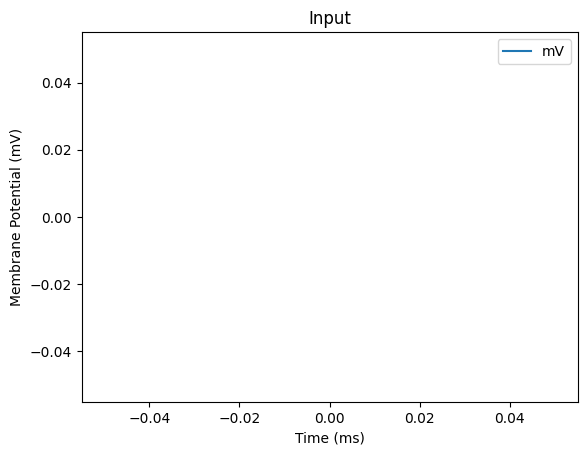

In [6]:
for key in st_keys:
    monitor = net[key]
    plt.plot(monitor.t / ms, monitor.v[0] / mV, label='mV')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.title('Input')
    plt.legend()
    plt.show()

    

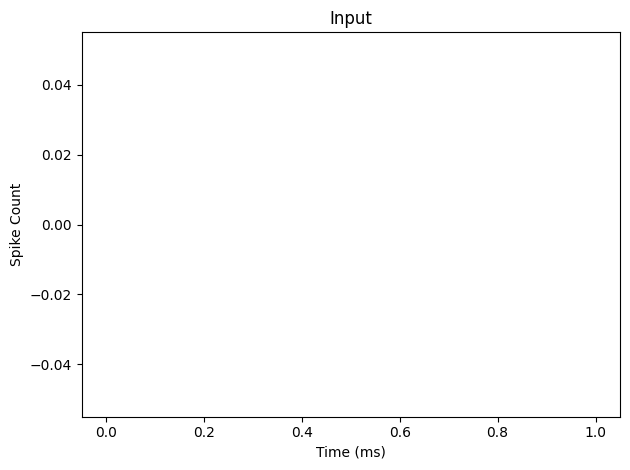

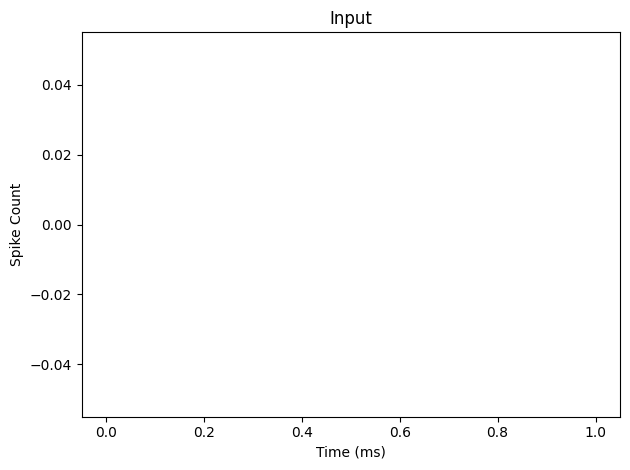

In [7]:
for key in sp_keys:
    monitor = net[key]
    plt.hist(monitor.t / ms, bins=10, alpha=0.7)
    plt.xlabel('Time (ms)')
    plt.ylabel('Spike Count')
    plt.title('Input')
    
    plt.tight_layout()
    plt.show()


    

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor.t / ms, monitor.v[0] / mV, label='mV')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Input')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor.t / ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Input')

plt.tight_layout()
plt.show()



## Other

WARNING    The object 'synapses' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipykernel_6599/3307002943.py', line 121, in <module>
    S = Synapses(neuron, neuron2, model=syn_eqs_exc, [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipykernel_6599/3307002943.py', line 46, in make_groups
    g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler') [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_1' is getting deleted, but was never included i

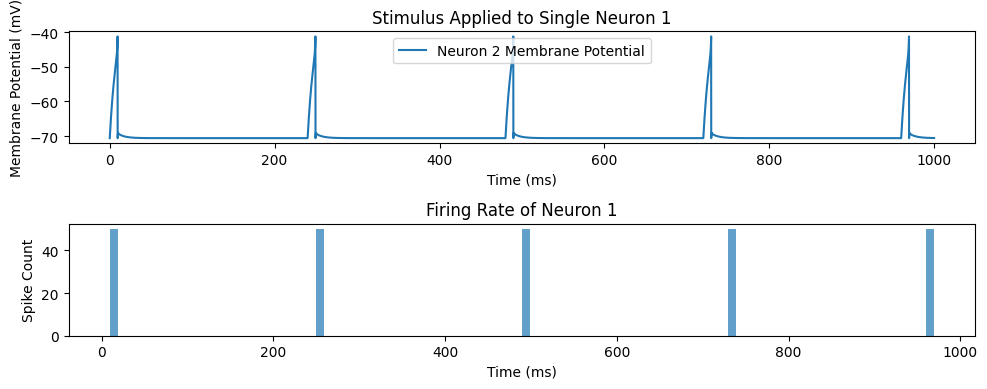

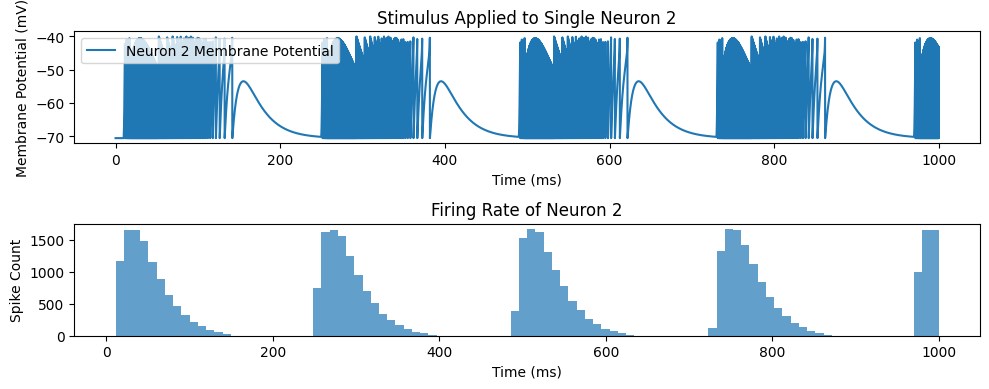

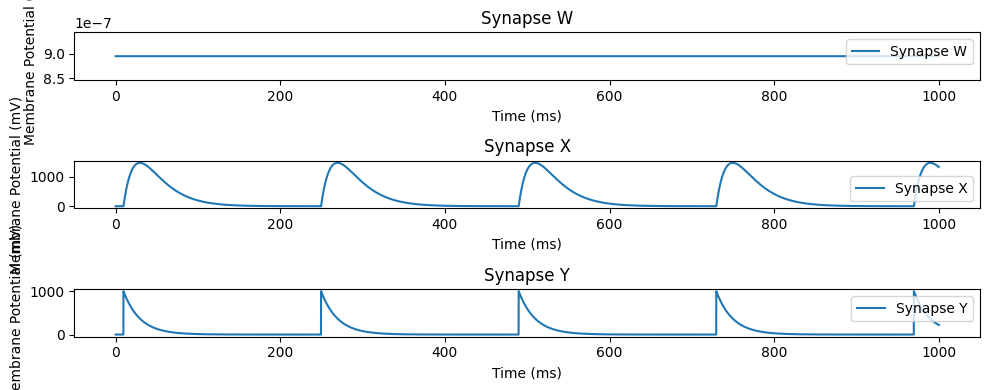

'\n0.6: 0\n0.625: 0\n0.63: 0.5\n0.65: 1.5\n0.7: 2.8\n0.8: 4.5\n1: 7.5\n1.5: 14\n2: 20\n'

In [2]:
import os

import time
import torch
import datetime
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils




from brian2 import prefs
#from brian2 import set_device
from brian2.devices import device_module

eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp

Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : 1   # Accumulate X values over a batch
running_sum_X : 1  # Sum of X during a stimulus
'''

def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for i, dim in enumerate(dims):
        if i == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups



# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 20 * ms  # Decay time constant for NMDA
w_init = 1 * nS   # Initial synaptic weight (conductance)

regularizer = 1 * nS



eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp

Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : 1   # Accumulate X values over a batch
running_sum_X : 1  # Sum of X during a stimulus
'''

eqs_neuron = '''
dv/dt = (-gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I = stimulus(t)  + Iexc: amp
Iexc : amp
'''

syn_eqs_exc = '''
w : siemens   # Synaptic weight, conductance
dX/dt = -X / tau_decay + Y / tau_rise : volt  (clock-driven)  # Spike trace
dY/dt = -Y / tau_decay : volt (clock-driven) # Glutamate decay
Iexc_post = w * X : amp (summed)
'''
neuron = make_groups([50], eqs = eqs_neuron)[0]
neuron2 = make_groups([50], eqs = eqs)[0]

neuron

# Change 2 to any value from 0.6 to 1.5, which is the range of current intensity we are probably going to use

stimulus = TimedArray(np.hstack([[c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] for c in np.ones(30)*1.2]) * nA, dt=10*ms)



neuron.v = EL
neuron.A = 0 * nA



S = Synapses(neuron, neuron2, model=syn_eqs_exc,
             on_pre='Y = 1*volt', method = "euler")  # Increment glutamate release on spike

S.connect()  # Random connections
S.w = 'rand() * w_init'  # Random initial weights

#S2 = Synapses(neuron2, neuron, model=syn_eqs_exc,
#             on_pre='Y = 1*volt', method = "euler")  # Increment glutamate release on spike

#S2.connect()  # Random connections
#S2.w = 'rand() * w_init * 0.01'  # Random initial weights

# Monitor the specific neuron (neuron 2)
monitor = StateMonitor(neuron, ['v', 'I'], record=[1])
spike_monitor = SpikeMonitor(neuron)


monitor2 = StateMonitor(neuron2, ['v', 'Iexc'], record=[1])
spike_monitor2 = SpikeMonitor(neuron2)


monitor3 = StateMonitor(S, ['X', 'Y', 'w'], record=[1])
#monitor4 = StateMonitor(S2, ['X', 'Y', 'w'], record=[1])

run(1 * second)

# Plot membrane potential
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor.t / ms, monitor.v[0] / mV, label='Neuron 2 Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Stimulus Applied to Single Neuron 1')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor.t / ms, bins=100, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate of Neuron 1')

plt.tight_layout()
plt.show()






plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor2.t / ms, monitor2.v[0] / mV, label='Neuron 2 Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Stimulus Applied to Single Neuron 2')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor2.t / ms, bins=100, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate of Neuron 2')

plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(3, 1, 1)
plt.plot(monitor3.t / ms, monitor3.w[0] / mV, label='Synapse W')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Synapse W')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(monitor3.t / ms, monitor3.X[0] / mV, label='Synapse X')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Synapse X')
plt.legend()



plt.subplot(3, 1, 3)
plt.plot(monitor3.t / ms, monitor3.Y[0] / mV, label='Synapse Y')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Synapse Y')
plt.legend()



plt.tight_layout()
plt.show()


'''
plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(3, 1, 1)
plt.plot(monitor4.t / ms, monitor3.w[0] / mV, label='Synapse2 W')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Synapse2 W')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(monitor4.t / ms, monitor3.X[0] / mV, label='Synapse2 X')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Synapse2 X')
plt.legend()



plt.subplot(3, 1, 3)
plt.plot(monitor4.t / ms, monitor3.Y[0] / mV, label='Synapse2 Y')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Synapse2 Y')
plt.legend()



plt.tight_layout()
plt.show()
'''




'''
0.6: 0
0.625: 0
0.63: 0.5
0.65: 1.5
0.7: 2.8
0.8: 4.5
1: 7.5
1.5: 14
2: 20
'''

In [3]:
import os

import time
import torch
import datetime
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils




from brian2 import prefs
#from brian2 import set_device
from brian2.devices import device_module


set_device("cpp_standalone", directory='project', build_on_run=False)

device = b2.get_device()



class SimWrapper:
    def __init__(self, net):
        self.net = net
        self.device = b2.get_device()
        self.device.build(run=False, directory="project2", clean = True)  # compile the code, but don't run it yet

    def do_run(self, net, tau_i):

        self.net = net
        
        # Workaround to set the device globally in this context

        device_module.active_device = self.device

        result_dir = f'result_{tau_i}'
        
        self.device.run(
            results_directory=result_dir
        )
        
        return self.net



eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp

Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : 1   # Accumulate X values over a batch
running_sum_X : 1  # Sum of X during a stimulus
'''
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for i, dim in enumerate(dims):
        if i == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups



# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 20 * ms  # Decay time constant for NMDA
w_init = 1 * nS   # Initial synaptic weight (conductance)

regularizer = 1 * nS



eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp

Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : 1   # Accumulate X values over a batch
running_sum_X : 1  # Sum of X during a stimulus
'''

eqs_neuron = '''
dv/dt = (-gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I = stimulus(t)  + Iexc: amp
Iexc : amp
'''

syn_eqs_exc = '''
w : siemens   # Synaptic weight, conductance
dX/dt = -X / tau_decay + Y / tau_rise : volt  (clock-driven)  # Spike trace
dY/dt = -Y / tau_decay : volt (clock-driven) # Glutamate decay
Iexc_post = w * X : amp (summed)
'''
neuron = make_groups([50], eqs = eqs_neuron)[0]
neuron2 = make_groups([50], eqs = eqs)[0]

neuron

# Change 2 to any value from 0.6 to 1.5, which is the range of current intensity we are probably going to use

stimulus = TimedArray(np.hstack([[c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] for c in np.ones(30)*1.2]) * nA, dt=10*ms)



neuron.v = EL
neuron.A = 0 * nA



S = Synapses(neuron, neuron2, model=syn_eqs_exc,
             on_pre='Y = 1*volt', method = "euler")  # Increment glutamate release on spike

S.connect()  # Random connections
S.w = 'rand() * w_init'  # Random initial weights

S2 = Synapses(neuron2, neuron, model=syn_eqs_exc,
             on_pre='Y = 1*volt', method = "euler")  # Increment glutamate release on spike

S2.connect()  # Random connections
S2.w = 'rand() * w_init * 0.01'  # Random initial weights

# Monitor the specific neuron (neuron 2)
monitor = StateMonitor(neuron, ['v', 'I'], record=[0])
spike_monitor = SpikeMonitor(neuron)


monitor2 = StateMonitor(neuron2, ['v', 'Iexc'], record=[0])
spike_monitor2 = SpikeMonitor(neuron2)


monitor3 = StateMonitor(S, ['X', 'Y', 'w'], record=[0])
monitor4 = StateMonitor(S2, ['X', 'Y', 'w'], record=[0])

run_time = 30*100*ms



net = Network(
    neuron,  # Add the first neuron group
    neuron2,  # Add the second neuron group
    S,  # Add the synapses from neuron to neuron2
    S2,  # Add the synapses from neuron2 to neuron
    monitor,  # Add the state monitor for neuron
    monitor2,  # Add the state monitor for neuron2
    monitor3,  # Add the state monitor for S
    monitor4,  # Add the state monitor for S2
    spike_monitor,  # Add the spike monitor for neuron
    spike_monitor2  # Add the spike monitor for neuron2,
)

net.stimulus = stimulus

net.run(run_time)

sim = SimWrapper(net)
'''
0.6: 0
0.625: 0
0.63: 0.5
0.65: 1.5
0.7: 2.8
0.8: 4.5
1: 7.5
1.5: 14
2: 20
'''

WARNING    Cannot check whether the indices to record from are valid. This can happen in standalone mode when recording from synapses that have been created with a connection pattern. You can avoid this situation by using synaptic indices in the connect call. [brian2.monitors.statemonitor.cannot_check_statemonitor_indices]
WARNING    Cannot check whether the indices to record from are valid. This can happen in standalone mode when recording from synapses that have been created with a connection pattern. You can avoid this situation by using synaptic indices in the connect call. [brian2.monitors.statemonitor.cannot_check_statemonitor_indices]


'\n0.6: 0\n0.625: 0\n0.63: 0.5\n0.65: 1.5\n0.7: 2.8\n0.8: 4.5\n1: 7.5\n1.5: 14\n2: 20\n'

In [4]:
net = sim.do_run(net, 1)

A


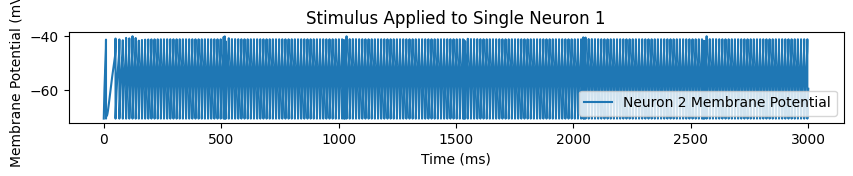

A


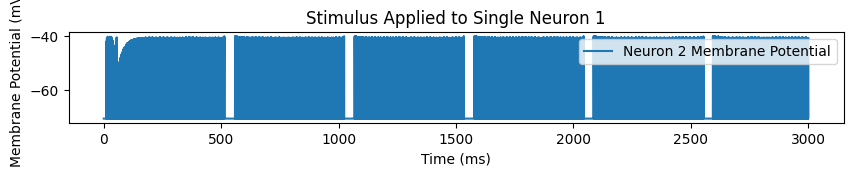

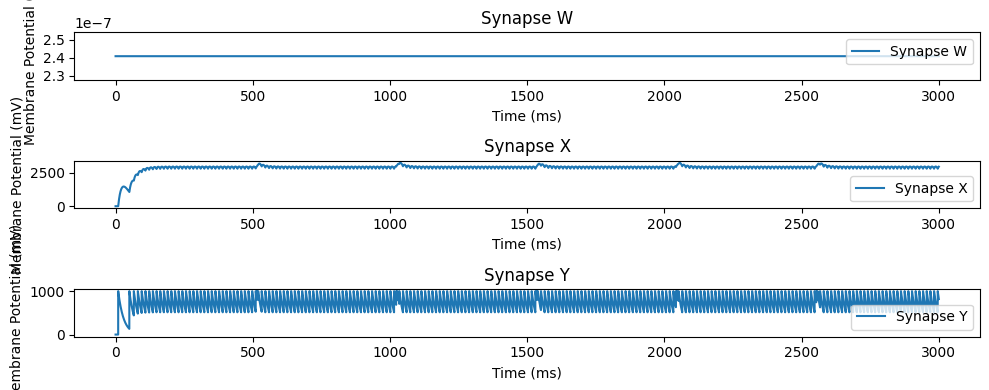

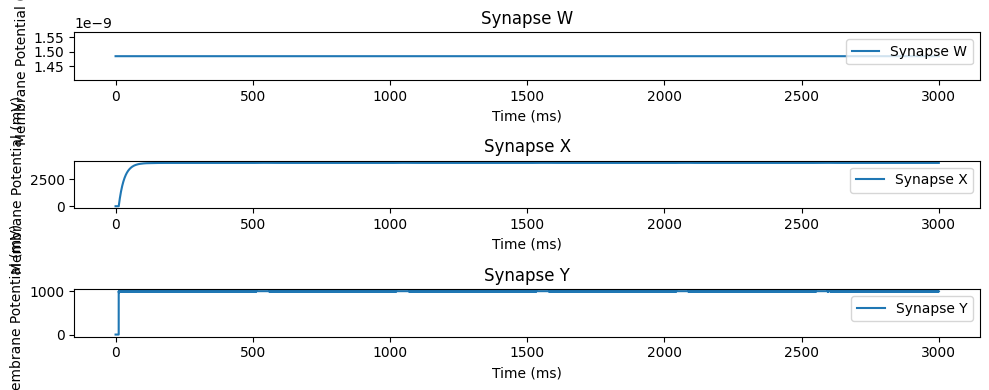

In [5]:
keys = []
states = net.get_states()
for key in states.keys():
    if "state" in key:
        keys.append(key)

for key in keys:
    monitor = net[key]
    try:
        plt.figure(figsize=(10, 4))
    
        # Membrane potential plot
        plt.subplot(3, 1, 1)
        plt.plot(monitor.t / ms, monitor.w[0] / mV, label='Synapse W')
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
        plt.title('Synapse W')
        plt.legend()
        
        
        plt.subplot(3, 1, 2)
        plt.plot(monitor.t / ms, monitor.X[0] / mV, label='Synapse X')
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
        plt.title('Synapse X')
        plt.legend()
        
        
        
        plt.subplot(3, 1, 3)
        plt.plot(monitor.t / ms, monitor.Y[0] / mV, label='Synapse Y')
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
        plt.title('Synapse Y')
        plt.legend()
        
        
        
        plt.tight_layout()
        plt.show()
    
    except:
        print("A")
        plt.plot(monitor.t / ms, monitor.v[0] / mV, label='Neuron 2 Membrane Potential')
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
        plt.title('Stimulus Applied to Single Neuron 1')
        plt.legend()
        plt.show()
        
        
        

In [ ]:
# Plot membrane potential
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor.t / ms, monitor.v[0] / mV, label='Neuron 2 Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Stimulus Applied to Single Neuron 1')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor.t / ms, bins=100, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate of Neuron 1')

plt.tight_layout()
plt.show()






plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor2.t / ms, monitor2.v[0] / mV, label='Neuron 2 Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Stimulus Applied to Single Neuron 2')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor2.t / ms, bins=100, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate of Neuron 2')

plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(3, 1, 1)
plt.plot(monitor3.t / ms, monitor3.w[0] / mV, label='Synapse W')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Synapse W')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(monitor3.t / ms, monitor3.X[0] / mV, label='Synapse X')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Synapse X')
plt.legend()



plt.subplot(3, 1, 3)
plt.plot(monitor3.t / ms, monitor3.Y[0] / mV, label='Synapse Y')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Synapse Y')
plt.legend()



plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(3, 1, 1)
plt.plot(monitor4.t / ms, monitor3.w[0] / mV, label='Synapse2 W')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Synapse2 W')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(monitor4.t / ms, monitor3.X[0] / mV, label='Synapse2 X')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Synapse2 X')
plt.legend()



plt.subplot(3, 1, 3)
plt.plot(monitor4.t / ms, monitor3.Y[0] / mV, label='Synapse2 Y')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Synapse2 Y')
plt.legend()



plt.tight_layout()
plt.show()



In [ ]:
# Let's connect 2 groups as a trial

G1 = NeuronGroup(5, 'v : volt', threshold='v > Vcut', reset='v = Vr', method='euler')  # Presynaptic neurons
G2 = NeuronGroup(5, eqs, threshold='v > Vcut', reset='v = Vr; A += b', method='euler')  # Postsynaptic neurons

# Initialize variables
G1.v = EL
G2.v = EL
G2.A = 0 * nA

# Create synapses
S = Synapses(G1, G2, model=syn_eqs_exc,
             on_pre='Y_post = 1*volt', method = "euler")  # Increment glutamate release on spike
S.connect(p=0.1)  # Random connections
S.w = 'rand() * w_init'  # Random initial weights

# Monitors
spike_mon_G1 = SpikeMonitor(G1)
spike_mon_G2 = SpikeMonitor(G2)
state_mon_G2 = StateMonitor(G2, ['v', 'I', 'A'], record=True)

# Run simulation
b2.run(500 * ms)

plt.figure(figsize=(12, 6))

# Plot membrane potential of a postsynaptic neuron
plt.subplot(311)
plt.plot(state_mon_G2.t / ms, state_mon_G2.v[0] / mV, label='Membrane potential (v)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
# TODO: Make weights always non-negative!

# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold
DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential
Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nS   # Initial synaptic weight (conductance)

# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I : amp  # Input current
'''

input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I = input_stimuli(t)  : amp
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I : amp  # Synaptic input (summed)
I_tot = I + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
w : siemens  # Synaptic weight (conductance)
I_post = w * X : amp (summed)
batch_sum_X : volt  # Accumulate X values over a batch
running_sum_X : volt  # Sum of X during a stimulus
'''

syn_eqs_inh= '''
dX/dt = -X / tau_decay + Y / tau_rise : volt  # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
w : siemens  # Synaptic weight (conductance)
I_post = w * X : amp (summed)
batch_sum_X : volt  # Accumulate X values over a batch
running_sum_X : volt  # Sum of X during a stimulus
'''

def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation

In [ ]:
# Update logic
@network_operation(dt = batch_size * msec_step * ms)
def update_sums( ):

    current_idx = int(defaultclock.t / msec_step*ms)

    if stimulus_indexes.values[current_idx] == 1:


        for n in range(len(Rs)-1):

            for i in range(len(Rs[n])):

                '''
                Rs[n].batch_sum_X[i] += Rs[n].X_[i]

                Es_0[n].batch_sum_X[i] += Es_0[n].X_[i]

                Es_1[n].batch_sum_X[i] += Es_1[n].X_[i]
                '''

                Rs[n].batch_sum_X += Rs[n].X_
                Es_0[n].batch_sum_X += Es_0[n].X_
                Es_1[n].batch_sum_X += Es_1[n].X_


@network_operation( dt = batch_size * msec_step * ms )
def apply_weight_update():

    print("Applying weight update")

    for n in range(len(Rs)-1):
        print("n: ", n)

        for i in range(len(Rs[n])):
            print("i: ", i)
            for j in range(len(Es_0[n])):
                print("j: ", j)


                S_p, S_m = connections[f"top_down_{n}"]

                S_p.w[i,j] += lr * Es_0[n].batch_sum_X[j] * Rs[n].batch_sum_X[i] * siemens

                S_m.w[i,j] += lr * Es_1[n].batch_sum_X[j] * Rs[n].batch_sum_X[i]  * siemens

                Rs[n].batch_sum_X[i] = 0

                Es_0[n].batch_sum_X[i]= 0

                Es_1[n].batch_sum_X[i] = 0



for stimulus_indexes, output_stimuli, input_stimuli in dl:

    print("indexes", stimulus_indexes.values.shape, stimulus_indexes.values)

    run((batch_size + batch_size*num_pause_blocks) * 100 * ms)